In [1]:
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torch.autograd import Variable

import time
import os
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#loading the train and test sets of CIFAR 10 and normalizing them
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:07<00:00, 23398651.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def gaussian(ins, mean=0, stddev=0.09):
    noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise

In [5]:
#Adding gaussian noise as a blackbox adversarial attack. We will be adding this to the test set as well to show reduced performance and thus, effectiveness of the model
transform_defense = transforms.Compose(
    [transforms.ToTensor(),
     gaussian,
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ])

batch_size = 32

trainset_defense = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_defense)
trainloader_defense = torch.utils.data.DataLoader(trainset_defense, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_defense = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_defense)
testloader_defense = torch.utils.data.DataLoader(testset_defense, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


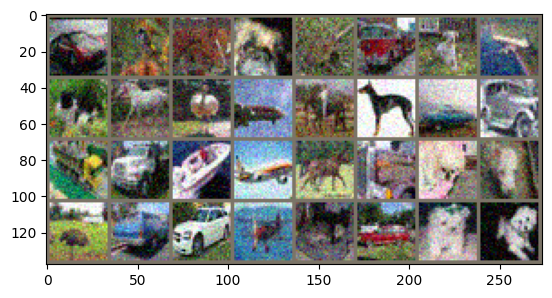

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img,means,vars):
    img = (img * vars) + means     # unnormalize
    npimg = img.numpy()
    # print(npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# # get some random training images
dataiter = iter(trainloader_defense)
images, labels = next(dataiter)

# show images
means = torch.tensor([0.485, 0.456, 0.406]).view((3,1,1))
vars = torch.tensor([0.229, 0.224, 0.225]).view((3,1,1))
imshow(torchvision.utils.make_grid(images),means,vars)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

car   bird  horse dog   frog  truck dog   plane cat   horse bird  plane horse dog   car   car   truck truck ship  plane horse truck dog   dog   bird  car   car   plane cat   car   dog   dog  
cuda:0


In [8]:
#define the resnet 18 model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 316MB/s]


In [9]:
# training loop. We use the minibatch gradient descent with momentum 
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.567
[1,   400] loss: 1.185
[1,   600] loss: 1.033
[1,   800] loss: 0.927
[1,  1000] loss: 0.908
[1,  1200] loss: 0.892
[1,  1400] loss: 0.816
[2,   200] loss: 0.654
[2,   400] loss: 0.669
[2,   600] loss: 0.652
[2,   800] loss: 0.681
[2,  1000] loss: 0.639
[2,  1200] loss: 0.665
[2,  1400] loss: 0.632
[3,   200] loss: 0.505
[3,   400] loss: 0.508
[3,   600] loss: 0.523
[3,   800] loss: 0.527
[3,  1000] loss: 0.507
[3,  1200] loss: 0.535
[3,  1400] loss: 0.519
[4,   200] loss: 0.392
[4,   400] loss: 0.395
[4,   600] loss: 0.396
[4,   800] loss: 0.441
[4,  1000] loss: 0.410
[4,  1200] loss: 0.423
[4,  1400] loss: 0.439
[5,   200] loss: 0.307
[5,   400] loss: 0.330
[5,   600] loss: 0.317
[5,   800] loss: 0.357
[5,  1000] loss: 0.343
[5,  1200] loss: 0.329
[5,  1400] loss: 0.362
[6,   200] loss: 0.241
[6,   400] loss: 0.246
[6,   600] loss: 0.284
[6,   800] loss: 0.272
[6,  1000] loss: 0.288
[6,  1200] loss: 0.292
[6,  1400] loss: 0.297
[7,   200] loss: 0.206
[7,   400] 

In [39]:
PATH = '/content/drive/MyDrive/cifar_net.pth'
torch.save(model_ft.state_dict(), PATH)

In [11]:
#model_ft.load_state_dict(torch.load("/content/drive/MyDrive/cifar_net.pth",map_location=device))

In [12]:
#accuracy on the train set
correct = 0
total = 0
all_train_X = []
all_train_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted = predicted.cpu()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 50K train images: {100 * correct // total} %')

Accuracy of the network on the 50K train images: 96 %


In [13]:
all_train_X = []
all_train_labels = []
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        all_train_X.append(images)
        all_train_labels.append(labels)

In [14]:
all_train_X = torch.cat(all_train_X, axis=0)
# print(all_train_X.shape)

In [15]:
all_train_labels = torch.cat(all_train_labels)
# print(all_train_labels.shape)

In [16]:
#performance on the test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted = predicted.cpu()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


In [17]:
model_ft = model_ft.to(device)

In [18]:
#performance on the adversarial test set, drop in accuracy by 6%
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_defense:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted = predicted.cpu()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 72 %


noise std dev vs acc vs drop \\
0.09 72% 8% \\
0.25 48% 32% \\
0.5 31% 49% \\
0.01 80% 0%\\

In [19]:
all_test_X = []
all_test_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        all_test_X.append(images)
        all_test_labels.append(labels)

In [20]:
all_adv_test_X = []
all_adv_test_labels = []
with torch.no_grad():
    for data in testloader_defense:
        images, labels = data
        all_adv_test_X.append(images)
        all_adv_test_labels.append(labels)

In [21]:
all_test_X = torch.cat(all_test_X, axis=0)
# print(all_test_X.shape)

In [22]:
all_test_labels = torch.cat(all_test_labels)
# print(all_test_labels.shape)

In [23]:
# all_train_X = torch.tensor(all_train_X)
# all_train_labels = torch.tensor(all_train_labels)
# all_test_X = torch.tensor(all_test_X)
# all_test_labels = torch.tensor(all_test_labels)

In [24]:
# # prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # again no gradients needed
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1


# # print accuracy for each class
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Adevrsarial Attack Generation

In [25]:
!pip install foolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [26]:
model_ft = model_ft.eval()

In [27]:
import foolbox as fb
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=1)
bounds = (-5, 5)
fmodel = fb.PyTorchModel(model_ft, bounds=bounds, preprocessing=None)

In [28]:
def adversarial_Acc(clipped,labels,model_ft,images=None):
    model_ft.eval()
    correct = 0
    total = 0
    predicted_labels = []
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        i=0
        for images_clipped,labels_clipped in (zip(clipped,labels)):
            images_clipped = images_clipped.unsqueeze(0)
            
            if images != None:
                original_images = images[i].unsqueeze(0)
                images_clipped = images_clipped.to(device)
                original_images = original_images.to(device)
                outputs_original = model_ft(original_images)
                _, predicted_original = torch.max(outputs_original.data, 1)
                predicted_original = predicted_original.cpu()


            label_clipped = labels[i]
            # calculate outputs by running images through the network
            outputs = model_ft(images_clipped)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
            predicted_labels.append(predicted)
            # print((predicted.item() == label_clipped.item()))
            correct = correct + (predicted.item() == label_clipped.item())
            i+=1
    print(f'Accuracy of the network on the test images: {100 * (correct / i)} %')
    if images is not None:
        return predicted_labels, predicted_original, labels
    else:
        return predicted_labels, labels

In [60]:
# LinfDeepFool Attack on 2000 elements of the test set
attack_deepfool = fb.attacks.LinfDeepFoolAttack()
raw_df, clipped_df, is_adv_df = attack_deepfool(fmodel, all_test_X.to(device), all_test_labels.to(device),epsilons = 0.02)

In [61]:
predicted_adv_df, labels_adv_df = adversarial_Acc(clipped_df, all_test_labels,model_ft)

Accuracy of the network on the test images: 25.14 %


In [62]:
#FGSM Attack
attack_fgsm = fb.attacks.FGSM()
raw_fgsm, clipped_fgsm, is_adv_fgsm = attack_fgsm(fmodel, all_test_X.to(device),all_test_labels.to(device),epsilons=0.02) 

In [63]:
predicted_adv_fgsm, labels_adv_fgsm = adversarial_Acc(clipped_fgsm, all_test_labels,model_ft)


Accuracy of the network on the test images: 27.55 %


In [64]:
predicted_adv_fgsm = torch.tensor(predicted_adv_fgsm)

In [65]:
predicted_adv_df = torch.tensor(predicted_adv_df)

In [66]:
# PGD Attack on 2000 elements of the test set
attack_deepfool = fb.attacks.LinfProjectedGradientDescentAttack()
raw_df, clipped_df, is_adv_df = attack_deepfool(fmodel, all_test_X.to(device), all_test_labels.to(device),epsilons = 0.02)

In [67]:
predicted_adv_df, labels_adv_df = adversarial_Acc(clipped_df, all_test_labels,model_ft)


Accuracy of the network on the test images: 24.310000000000002 %


In [68]:
# CW Attack on 200 elements of the test set
attack_deepfool = fb.attacks.L2CarliniWagnerAttack()
raw_df, clipped_df, is_adv_df = attack_deepfool(fmodel, all_test_X[:200].to(device), all_test_labels[:200].to(device),epsilons = 0.02)

In [69]:
predicted_adv_df, labels_adv_df = adversarial_Acc(clipped_df, all_test_labels[:200],model_ft)


Accuracy of the network on the test images: 57.49999999999999 %


eps 0.002 - Accuracy of the network on the test images: 54.31 % deepfool
54.36 % fgsm 54.75 % pgd 58.5 CW

eps 0.02 - Accuracy of the network on the test images: 25.14 % % deepfool
27.55 % % fgsm 24.31 % pgd 57.5 CW

eps 0.2 - Accuracy of the network on the test images: 0.01 % deepfool
6.67 % fgsm 0.6 % pgd 53.5 CW

Adversarial Defense - Adding adversarial images from training set to training set

In [ ]:
#training a model on the train data along with the train data with added noise
model_ft_defense = models.resnet18(pretrained=True)
num_ftrs = model_ft_defense.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_defense.fc = nn.Linear(num_ftrs, 10)
model_ft_defense = model_ft_defense.to(device)
criterion_defense = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_defense1 = optim.RMSprop(model_ft_defense.parameters(), lr=0.01)
optimizer_defense2 = optim.SGD(model_ft_defense.parameters(), lr=0.001, momentum=0.9)
# optimizer_defense3 = optim.SGD(model_ft_defense.parameters(), lr=0.0001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#training loop
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader_defense, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_defense2.zero_grad()

        # forward + backward + optimize
        outputs = model_ft_defense(inputs)
        loss = criterion_defense(outputs, labels)
        loss.backward()

        optimizer_defense2.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.642
[1,   400] loss: 1.249
[1,   600] loss: 1.144
[1,   800] loss: 1.042
[1,  1000] loss: 1.022
[1,  1200] loss: 0.978
[1,  1400] loss: 0.911
[2,   200] loss: 0.824
[2,   400] loss: 0.817
[2,   600] loss: 0.811
[2,   800] loss: 0.799
[2,  1000] loss: 0.806
[2,  1200] loss: 0.775
[2,  1400] loss: 0.792
[3,   200] loss: 0.698
[3,   400] loss: 0.684
[3,   600] loss: 0.704
[3,   800] loss: 0.694
[3,  1000] loss: 0.663
[3,  1200] loss: 0.655
[3,  1400] loss: 0.718
[4,   200] loss: 0.604
[4,   400] loss: 0.607
[4,   600] loss: 0.606
[4,   800] loss: 0.601
[4,  1000] loss: 0.615
[4,  1200] loss: 0.619
[4,  1400] loss: 0.603
[5,   200] loss: 0.533
[5,   400] loss: 0.533
[5,   600] loss: 0.542
[5,   800] loss: 0.544
[5,  1000] loss: 0.535
[5,  1200] loss: 0.537
[5,  1400] loss: 0.543
[6,   200] loss: 0.463
[6,   400] loss: 0.466
[6,   600] loss: 0.474
[6,   800] loss: 0.465
[6,  1000] loss: 0.474
[6,  1200] loss: 0.491
[6,  1400] loss: 0.498
[7,   200] loss: 0.430
[7,   400] 

In [ ]:
torch.save(model_ft_defense.cpu().state_dict(), "/content/drive/MyDrive/cifar_net_w_adv.pth")

In [ ]:
model_t_defense = model_ft_defense.to(device)

In [ ]:
#test the adversarial defense model on original test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft_defense(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted = predicted.cpu()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


In [ ]:
#test the adversarial defense on the adversarial test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_defense:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft_defense(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted = predicted.cpu()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 77 %


Visualization

In [ ]:
means = torch.tensor([0.485, 0.456, 0.406]).view((3,1,1))
vars = torch.tensor([0.229, 0.224, 0.225]).view((3,1,1))
idx=16
img_df = ((clipped_df[idx].cpu()*vars)+means).numpy().transpose((1,2,0))
img_fgsm = ((clipped_df[idx].cpu()*vars)+means).numpy().transpose((1,2,0))
img_ori = ((all_test_X[idx].cpu()*vars)+means).numpy().transpose((1,2,0))


dog


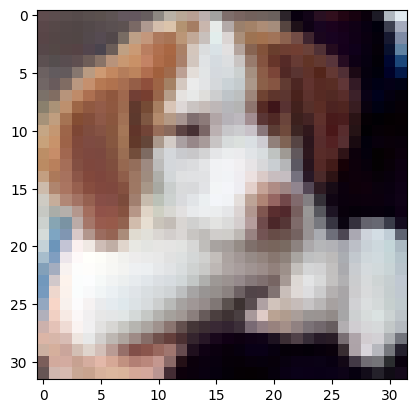

In [ ]:
plt.imshow(img_ori)
print(classes[all_test_labels[idx].item()])

cat


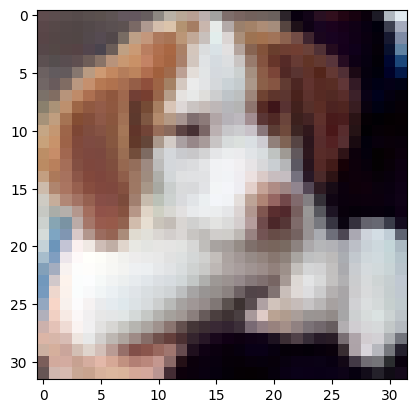

In [ ]:
plt.imshow(img_df)
print(classes[predicted_adv_df[idx].item()])

cat


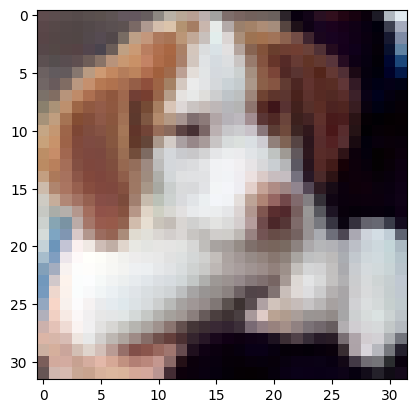

In [ ]:
plt.imshow(img_fgsm)
print(classes[predicted_adv_fgsm[idx].item()])

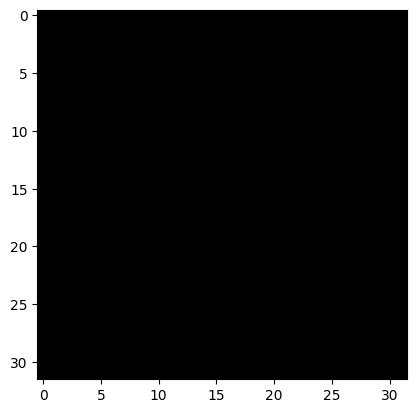

In [ ]:
plt.imshow(np.abs(img_ori - img_fgsm))

In [ ]:
np.abs(img_ori - img_fgsm).any()

False